<a href="https://colab.research.google.com/github/trancenoid/GANs/blob/master/audioGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir './tracks'


In [0]:
!cp './drive/My Drive/audioGAN_data/piano/A_h3kt6Dp9M' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/ET15VTJN-e0' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/pj1jHGU4a4g' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/3hr' ./tracks/

In [0]:
!cp ./tracks/A_h3kt6Dp9M './drive/My Drive/audioGAN_data/piano'
!cp ./tracks/ET15VTJN-e0 './drive/My Drive/audioGAN_data/piano'
!cp ./tracks/pj1jHGU4a4g './drive/My Drive/audioGAN_data/piano'

In [2]:
% pylab inline
import librosa
from librosa.display import waveplot,specshow
import os
import IPython.display as ipd
import pandas as pd
import glob 
from librosa.core import stft, istft
import keras
from keras.layers import *
from keras import initializers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Model, Sequential
from tqdm import tqdm
import numpy as np
import re


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [8]:
print(os.listdir('./tracks'))
#!rmdir './tracks/.ipynb_checkpoints'

['A_h3kt6Dp9M', 'ET15VTJN-e0', '3hr', 'pj1jHGU4a4g']


In [0]:

#tracks = os.listdir('./drive/My Drive/audioGAN_data')
tracks = os.listdir('./tracks')
sr = 8191
clip_len = 8
#data, sampling_rate = librosa.load('016 - Timbaland ft. Keri Hilson - The Way I Are.MP3', sr = 8192)
def load_data():
  nt = len(tracks)
  X = []
  for track in tqdm(tracks):
    #data, _ = librosa.load('./drive/My Drive/audioGAN_data/' + track, sr = sr)
    data, _ = librosa.load('./tracks/' + track, sr = sr)
    data = [ np.array(stft(data[(i*clip_len*sr):((i+1)*clip_len*sr)]))[0:-1, :] for i in tqdm(range( int(len(data)/(clip_len*sr)) - 1 ))]
    X.extend(data)
  data = np.array(X)
  print(data.shape)
  X = np.zeros(data.shape)
  Y = np.zeros(data.shape)
  for i in tqdm(range(data.shape[0])):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        #Y[i,j,k] = re.findall( '(-*[0-9]+\.[0-9]+)(?:[\+|\-])([0-9]+)', X[i,j,k])[0][0]
        temp = re.findall( '(-?[0-9]+\.?[0-9]+(e[\+|\-][0-9]+)?)?([\+|\-]?[0-9]+\.?[0-9]*(e[\+|\-][0-9]+)?)j',
                          str(data[i,j,k]))
        try:
          if(temp[0][0] != ''):
            X[i,j,k] = float(temp[0][0])
          else:
            X[i,j,k] = 0.0
          Y[i,j,k] = float(temp[0][2])
        except IndexError as e:
          print(data[i,j,k])
  np.save('./X', X)
  np.save('./Y', Y)
  !mv './X.npy' './drive/My Drive/audioGAN_data/piano/'
  !mv './Y.npy' './drive/My Drive/audioGAN_data/piano/'
#X = np.array(load_data()).transpose([1,2,3,0])
load_data()

In [0]:
!cp './drive/My Drive/audioGAN_data/piano/X.npy' './X.npy'
!cp './drive/My Drive/audioGAN_data/piano/Y.npy' './Y.npy'

In [0]:
!mv './data.npy' './drive/My Drive/audioGAN_data/piano/'

In [0]:
X = np.load('X.npy', mmap_mode = 'r')
Y = np.load('Y.npy', mmap_mode = 'r')

In [8]:
X = np.stack([X,Y]).transpose([1,2,3,0])
print(X.shape)
np.save('./X', X)

(3033, 1024, 128, 2)


In [0]:
np.save('./X', X)


In [0]:
!cp './X.npy' './drive/My Drive/audioGAN_data/piano/train'

In [0]:
!cp './drive/My Drive/audioGAN_data/piano/train' './data.npy'
X = np.load('data.npy', mmap_mode = 'r')


In [0]:
X.shape

(3041, 1024, 128, 2)

In [0]:
adam = Adam(lr = 0.0002, beta_1 = 0.5)
inShape = 100

def build_gen():
  
  G = Sequential()
  G.add(Dense(64*8*2, input_shape = (100,), activation = 'relu'))
  G.add(Reshape([64,8,2]))
  
  G.add(Conv2D(8,kernel_size = (5,3), strides = (1,1), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  
  G.add(Conv2DTranspose(16, strides = 2 ,kernel_size = (5,3), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  #G.add(Dropout(0.3))
  
  G.add(Conv2D(16,kernel_size = (5,3), strides = (1,1), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  
  G.add(Conv2DTranspose(16, strides = 2 ,kernel_size = (5,3), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  #G.add(Dropout(0.3))
  
  G.add(Conv2D(16,kernel_size = (5,3), strides = (1,1), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  
  G.add(Conv2DTranspose(16, strides = 2 ,kernel_size = (5,3), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  #G.add(Dropout(0.3))
  
  G.add(Conv2D(16,kernel_size = (5,3), strides = (1,1), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  
  G.add(Conv2DTranspose(16, strides = 2 ,kernel_size = (5,3), padding = 'same'))
  G.add(BatchNormalization(momentum = 0.9))
  G.add(LeakyReLU(0.1))
  #G.add(Dropout(0.3))
  
  G.add(Conv2D(2, kernel_size = (5,3), padding = 'same', activation = 'tanh'))
  
  return G  
    

def build_dis():
  D = Sequential()
  
  D.add(Conv2D(128,(5,3), strides = (2,2), padding = 'same', input_shape = [1024,128,2,]))
  D.add(BatchNormalization(momentum = 0.9))
  D.add(LeakyReLU(0.1))
  
  D.add(Conv2D(64,(5,3), strides = (2,2), padding = 'same'))
  D.add(BatchNormalization(momentum = 0.9))
  D.add(LeakyReLU(0.1))
  
  D.add(Conv2D(32,(5,3), strides = (2,2), padding = 'same'))
  D.add(BatchNormalization(momentum = 0.9))
  D.add(LeakyReLU(0.1))
  
  D.add(Conv2D(2,(5,3), strides = (2,2), padding = 'same'))
  D.add(BatchNormalization(momentum = 0.9))
  D.add(LeakyReLU(0.1))
  D.add(Flatten())
  
  D.add(Dense(1))
  D.compile(loss = 'binary_crossentropy', optimizer = adam)
  
  return D
D = build_dis()
G = build_gen()

D.trainable = False
ganIn = Input(shape = (inShape,))
genOut = G(ganIn)
ganOut = D(genOut)
GAN = Model(inputs = ganIn, outputs = ganOut)
GAN.compile(loss = 'binary_crossentropy', optimizer = adam)

In [23]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 512, 64, 128)      3968      
_________________________________________________________________
batch_normalization_56 (Batc (None, 512, 64, 128)      512       
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 512, 64, 128)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 256, 32, 64)       122944    
_________________________________________________________________
batch_normalization_57 (Batc (None, 256, 32, 64)       256       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 256, 32, 64)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 16, 32)       30752     
__________

In [0]:
X = np.load('data.npy', mmap_mode = 'r')
sr = 8191
dLosses = []
gLosses = []
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('dcgan_loss_epoch_%d.png' % epoch)
    
def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def play_clips(batchidx):
  noise = generate_noise(5, 100)
  pred = G.predict(noise)
  ans = np.zeros((pred.shape[0], pred.shape[1], pred.shape[2]), dtype = complex)
  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      for k in range(pred.shape[2]):
        if(str(pred[i,j,k,1])[0] != '-'):
          ans[i,j,k] = complex(str(pred[i,j,k,0]) + '+' + str(pred[i,j,k,1]) + 'j')
        else:
          ans[i,j,k] = complex(str(pred[i,j,k,0]) + str(pred[i,j,k,1]) + 'j')

  for i in range(1):
    ipd.Audio(data = istft(ans[i]), rate = sr)
    
def loadWeights(epoch):
  G.load_weights('./drive/My Drive/audio_model/G_epoch_Conv_%d.h5' % epoch)
  D.load_weights('./drive/My Drive/audio_model/D_epoch_Conv_%d.h5' % epoch)

def saveModels(epoch):
  G.save('./drive/My Drive/audio_model/G_epoch_Conv_%d.h5' % epoch)
  D.save('./drive/My Drive/audio_model/D_epoch_Conv_%d.h5' % epoch)

In [0]:


def train(epochs=1, BATCH_SIZE=16, resume_at = 0):
  if (resume_at != 0) : 
    loadWeights(resume_at)
    start = resume_at
  else:
    start = 0
  num_batches = int(X.shape[0]/BATCH_SIZE)
  N_EPOCHS = epochs
  for epoch in range(start, start + N_EPOCHS):

    cum_d_loss = 0.
    cum_g_loss = 0.

    for batch_idx in tqdm(range(num_batches)):
      clips = X[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

      noise_data = generate_noise(BATCH_SIZE, 100)
      generated_clips = G.predict(noise_data)
      noise_prop = 0.05

      true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
      flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
      true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
      D.trainable = True 

      d_loss_true = D.train_on_batch(clips, true_labels)
      gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
      flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
      gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
      
    
      d_loss_gene = D.train_on_batch(generated_clips, gene_labels)
      #d_loss_gene, d_loss_true = (0,0)
      D.trainable = False
      d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
      cum_d_loss += d_loss

      noise_data = generate_noise(BATCH_SIZE, 100)
      g_loss = GAN.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
      cum_g_loss += g_loss
    print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    if( (epoch+1)%5 == 0): 
      play_clips("epoch" + str(epoch))
      saveModels(epoch)

if __name__ == '__main__':
  train(600, 32, resume_at = 0)

 29%|██▊       | 27/94 [01:14<02:35,  2.32s/it]

In [7]:
sr = 8191
#X = np.load('data.npy')
loadWeights(539)
pred = G.predict(np.random.normal(0, 1, size=(1, 100)))
print(D.predict(np.array([X[0]]).transpose(0,2,1,3)))
print(D.predict(pred))
#pred = []
#pred = np.array([X[0]])
print(pred[0].shape)
ans = np.zeros((pred.shape[1], pred.shape[2]), dtype = complex)
#print(D.predict(pred))
for i in range(pred[0].shape[0]):
    for j in range(pred[0].shape[1]):
      if(str(pred[0,i,j,1])[0] != '-'):
        #print(str(pred[0,i,j,0]) + '+' + str(pred[0,i,j,1])) 
        ans[i,j] = complex(str(pred[0,i,j,0]) + '+' + str(pred[0,i,j,1]) + 'j')
      else:
        #print(str(pred[0,i,j,0]) + str(pred[0,i,j,1])) 
        ans[i,j] = complex(str(pred[0,i,j,0]) + str(pred[0,i,j,1]) + 'j')
      
ans = istft(ans)
ipd.Audio(data = ans, rate = sr)

W0716 07:51:07.513699 140158793828224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[[0.05086072]]
[[0.951733]]
(128, 1024, 2)


In [0]:
D.train_on_batch

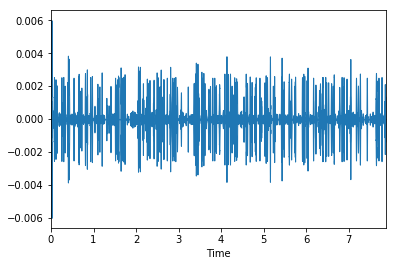

In [8]:
waveplot(ans, sr)

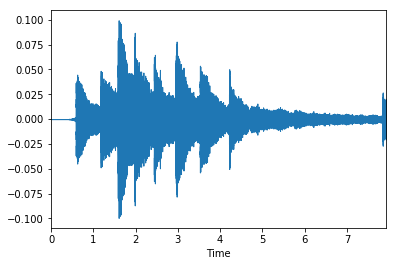

In [25]:
waveplot(ans, sr)

In [18]:
X.shape

(341, 1024, 128)

In [28]:
print(ans)

[0.         0.         0.         ... 0.0124409  0.01920281 0.02014092]


In [27]:
rr = [[1,2],[3,4],[5,6]]
B = []
B.extend(rr)
B[1]

[3, 4]

In [28]:
X

array([[[ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
         -6.90312730e-03+0.0000000e+00j,  2.87001431e-02+0.0000000e+00j,
          1.49466857e-01+0.0000000e+00j],
        [ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
          1.77159403e-02-4.3430823e-04j, -1.59279909e-02+3.5510767e-02j,
         -4.52934913e-02+8.4350735e-02j],
        [ 0.00000000e+00-0.0000000e+00j,  0.00000000e+00-0.0000000e+00j,
          0.00000000e+00-0.0000000e+00j, ...,
         -1.73118971e-02+9.2996489e-03j,  3.02878371e-03-2.3090495e-02j,
         -7.29393214e-02+4.7391155e-03j],
        ...,
        [ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
         -1.28261890e-04-1.8711382e-05j,  1.46490484e-05-4.1601194e-05j,
          5.03309246e-04+5.8999825e-03j],
        [ 0.00000000e+00+0.0000000e+00j,  0.0000000

In [0]:
B, _ = librosa.load('./tracks/A_h3kt6Dp9M', sr = sr)

In [0]:
rr = istft(stft(B[8*sr:16*sr]))

In [36]:
ipd.Audio(data = rr, rate = sr)